In [118]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2023-03-15'
TEST_START_DATE = '2023-03-15'
TEST_END_DATE = '2024-10-30'

TRAINED_PPO = "/2022_train/model_checkpoint_3000000_steps"


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]


GRAPH_TITLE = "PPO Trained 2009-04-01 to 2023-03-15, Three Million Time Steps Checkpoint"


# Backtest the results


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader



df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (21072, 8)


In [119]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.03645533 0.04490015 0.03917915]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 1.   0.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.020355,0.021279,0.020714,0.018285,0.313329,AAPL,0.50
1,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.50
2,2009-04-01,0.216569,0.221100,0.217204,0.153140,0.377145,INTC,0.50
3,2009-04-01,0.052899,0.055366,0.053127,0.042764,0.302015,MSFT,0.50
4,2009-04-01,0.054739,0.055408,0.054015,0.049621,0.130785,V,0.50
...,...,...,...,...,...,...,...,...
21067,2023-03-14,0.465303,0.478823,0.465708,0.481710,0.079890,BA,0.25
21068,2023-03-14,0.401026,0.405542,0.404843,0.440352,0.239644,INTC,0.25
21069,2023-03-14,0.745024,0.746618,0.747691,0.769121,0.105288,MSFT,0.25
21070,2023-03-14,0.871826,0.870186,0.870357,0.882460,0.023659,V,0.25


# PPO On portfolio Opt

In [120]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime



environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [121]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
# trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_10_27") 


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [122]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "train": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["train"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["train"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["train"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


print(df_ppo_opt.loc[0, 'Date'])


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 10229185.0
Final accumulative portfolio value: 10.229185
Maximum DrawDown: -0.337933072245873
Sharpe ratio: 1.0112590318537773
Total commission cost: 240991.6146771598
hit end!
      ppo_opt_net_worth       Date
0          1.000000e+06 2009-04-01
1          1.026441e+06 2009-04-02
2          1.047262e+06 2009-04-03
3          1.048266e+06 2009-04-06
4          1.024236e+06 2009-04-07
...                 ...        ...
3507       1.011681e+07 2023-03-08
3508       1.003104e+07 2023-03-09
3509       1.002716e+07 2023-03-10
3510       1.005339e+07 2023-03-13
3511       1.022918e+07 2023-03-14

[3512 rows x 2 columns]
2009-04-01 00:00:00


In [123]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2009-04-01 00:00:00')

# Porfolio Baselines

In [124]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment_benchmark = PortfolioOptimizationEnv(
    processed_test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


In [125]:
# CRP 

CRP_results = {
    "train": {},
}

environment_benchmark.reset()
agent_crp = DRLStableAgent(env = environment_benchmark)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmark)
CRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
CRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["train"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["train"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 13069710.0
Final accumulative portfolio value: 13.06971
Maximum DrawDown: -0.35611452276788824
Sharpe ratio: 1.0179817188950273
Total commission cost: 190027.35461968428
hit end!
      crp_opt_net_worth       Date
0          1.000000e+06 2009-04-01
1          1.028276e+06 2009-04-02
2          1.047790e+06 2009-04-03
3          1.048792e+06 2009-04-06
4          1.022953e+06 2009-04-07
...                 ...        ...
3507       1.288118e+07 2023-03-08
3508       1.277812e+07 2023-03-09
3509       1.275858e+07 2023-03-10
3510       1.280403e+07 2023-03-13
3511       1.306971e+07 2023-03-14

[3512 rows x 2 columns]


In [126]:
# BAH

BAH_results = {
    "train": {},
}

environment_benchmark.reset()
agent_bah = DRLStableAgent(env = environment_benchmark)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmark)
BAH_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BAH_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["train"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["train"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 16020297.0
Final accumulative portfolio value: 16.020297
Maximum DrawDown: -0.363180442155278
Sharpe ratio: 1.0362453286454816
Total commission cost: 0.0
hit end!
      bah_opt_net_worth       Date
0          1.000000e+06 2009-04-01
1          1.028276e+06 2009-04-02
2          1.048011e+06 2009-04-03
3          1.048998e+06 2009-04-06
4          1.022652e+06 2009-04-07
...                 ...        ...
3507       1.596555e+07 2023-03-08
3508       1.577199e+07 2023-03-09
3509       1.559506e+07 2023-03-10
3510       1.573204e+07 2023-03-13
3511       1.602030e+07 2023-03-14

[3512 rows x 2 columns]


In [127]:
# OLMAR

OLMAR_results = {
    "train": {},
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}



environment_benchmark.reset()
agent_olmar = DRLStableAgent(env = environment_benchmark)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmark)
OLMAR_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
OLMAR_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["train"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["train"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3966011.0
Final accumulative portfolio value: 3.966011
Maximum DrawDown: -0.7357712105950993
Sharpe ratio: 0.45968319129573376
Total commission cost: 2309918.1206724085
hit end!
      olmar_opt_net_worth       Date
0            1.000000e+06 2009-04-01
1            1.028276e+06 2009-04-02
2            1.040092e+06 2009-04-03
3            1.021600e+06 2009-04-06
4            9.898611e+05 2009-04-07
...                   ...        ...
3507         3.761887e+06 2023-03-08
3508         3.828495e+06 2023-03-09
3509         3.941438e+06 2023-03-10
3510         3.945046e+06 2023-03-13
3511         3.966011e+06 2023-03-14

[3512 rows x 2 columns]


In [128]:
# RMR 

RMR_results = {
    "train": {},
}

RMR_model_kwargs = {
    "eps": 60,
    "window": 100
}

environment_benchmark.reset()
agent_rmr = DRLStableAgent(env = environment_benchmark)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=RMR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmark)
RMR_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
RMR_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["train"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["train"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 29539746.0
Final accumulative portfolio value: 29.539746
Maximum DrawDown: -0.43797180097651645
Sharpe ratio: 0.9865277859372992
Total commission cost: 59349.00317322521
hit end!
      rmr_opt_net_worth       Date
0          1.000000e+06 2009-04-01
1          1.028276e+06 2009-04-02
2          1.040092e+06 2009-04-03
3          1.021600e+06 2009-04-06
4          9.898611e+05 2009-04-07
...                 ...        ...
3507       2.959395e+07 2023-03-08
3508       2.915256e+07 2023-03-09
3509       2.874797e+07 2023-03-10
3510       2.912934e+07 2023-03-13
3511       2.953975e+07 2023-03-14

[3512 rows x 2 columns]


In [129]:
# BNN

BNN_results = {
    "train": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_bnn = DRLStableAgent(env = environment_benchmark)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmark)
BNN_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BNN_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["train"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["train"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 25799006.0
Final accumulative portfolio value: 25.799006
Maximum DrawDown: -0.4379717159802927
Sharpe ratio: 0.9546291320031867
Total commission cost: 132299.85294464102
hit end!
      bnn_opt_net_worth       Date
0             1000000.0 2009-04-01
1             1000000.0 2009-04-02
2             1000000.0 2009-04-03
3             1000000.0 2009-04-06
4             1000000.0 2009-04-07
...                 ...        ...
3507         25846348.0 2023-03-08
3508         25460856.0 2023-03-09
3509         25107494.0 2023-03-10
3510         25440572.0 2023-03-13
3511         25799006.0 2023-03-14

[3512 rows x 2 columns]


In [130]:
# SCRP


SCRP_results = {
    "train": {},
}


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": None
}

environment_benchmark.reset()
agent_scrp = DRLStableAgent(env = environment_benchmark)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmark)
SCRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
SCRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["train"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["train"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 29884096.0
Final accumulative portfolio value: 29.884096
Maximum DrawDown: -0.4379719470740324
Sharpe ratio: 0.9909480335996701
Total commission cost: 15542.403210868128
hit end!
      scrp_opt_net_worth       Date
0           1.000000e+06 2009-04-01
1           1.028276e+06 2009-04-02
2           1.040092e+06 2009-04-03
3           1.021600e+06 2009-04-06
4           9.873908e+05 2009-04-07
...                  ...        ...
3507        2.993893e+07 2023-03-08
3508        2.949240e+07 2023-03-09
3509        2.908309e+07 2023-03-10
3510        2.946890e+07 2023-03-13
3511        2.988410e+07 2023-03-14

[3512 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [131]:
# bcrp

BCRP_results = {
    "train": {},
}

environment_benchmark.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmark)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmark)
BCRP_results["train"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BCRP_results["train"]["date"] = environment_benchmark._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["train"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["train"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 46185464.0
Final accumulative portfolio value: 46.185464
Maximum DrawDown: -0.4379716838620611
Sharpe ratio: 1.1044531395347839
Total commission cost: 0.0
hit end!
      bcrp_opt_net_worth       Date
0           1.000000e+06 2009-04-01
1           1.036986e+06 2009-04-02
2           1.067164e+06 2009-04-03
3           1.089797e+06 2009-04-06
4           1.058055e+06 2009-04-07
...                  ...        ...
3507        4.627022e+07 2023-03-08
3508        4.558011e+07 2023-03-09
3509        4.494752e+07 2023-03-10
3510        4.554379e+07 2023-03-13
3511        4.618546e+07 2023-03-14

[3512 rows x 2 columns]


# Stock environment optimization algorithm

In [132]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [133]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_ppo_date.loc[0,'Date'],
        end = df_ppo_date.loc[len(df_ppo_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_ppo_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3511, 8)
Annual return          0.106570
Cumulative returns     3.099559
Annual volatility      0.172716
Sharpe ratio           0.673301
Calmar ratio           0.287358
Stability              0.970824
Max drawdown          -0.370862
Omega ratio            1.138867
Sortino ratio          0.942046
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970660
Daily value at risk   -0.021299
dtype: float64
df_dji:             date           dji
0    2009-04-01  1.000000e+06
1    2009-04-02  1.027891e+06
2    2009-04-03  1.032982e+06
3    2009-04-06  1.027604e+06
4    2009-04-07  1.003602e+06
...         ...           ...
3507 2023-03-08  4.225726e+06
3508 2023-03-09  4.155697e+06
3509 2023-03-10  4.111219e+06
3510 2023-03-13  4.099559e+06
3511 2023-03-14           NaN

[3512 rows x 2 columns]
df_dji:                       dji
date                    
2009-04-01  1.000000e+06
2009-04-02  1.027891e+06
2009-04-03  1.032982e+06
2009-04-06

# Compare all results

In [134]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')
# olmar = pd.read_csv('OLMAR_net_worth.csv')



# merged_df = olmar
# merged_df = pd.merge(merged_df, olmar, on='Date')

# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')


print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2009-04-01  1.000000e+06
2009-04-02  1.027891e+06
2009-04-03  1.032982e+06
2009-04-06  1.027604e+06
2009-04-07  1.003602e+06
...                  ...
2023-03-08  4.225726e+06
2023-03-09  4.155697e+06
2023-03-10  4.111219e+06
2023-03-13  4.099559e+06
2023-03-14           NaN

[3512 rows x 1 columns]
      crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1.000000e+06 2009-04-01        1.000000e+06       1.000000e+06   
1          1.028276e+06 2009-04-02        1.036986e+06       1.028276e+06   
2          1.047790e+06 2009-04-03        1.067164e+06       1.048011e+06   
3          1.048792e+06 2009-04-06        1.089797e+06       1.048998e+06   
4          1.022953e+06 2009-04-07        1.058055e+06       1.022652e+06   
...                 ...        ...                 ...                ...   
3507       1.288118e+07 2023-03-08        4.627022e+07       1.596555e+07   
3508       1.277812e+07 2023-03-09

# Baseline CRP in the environment

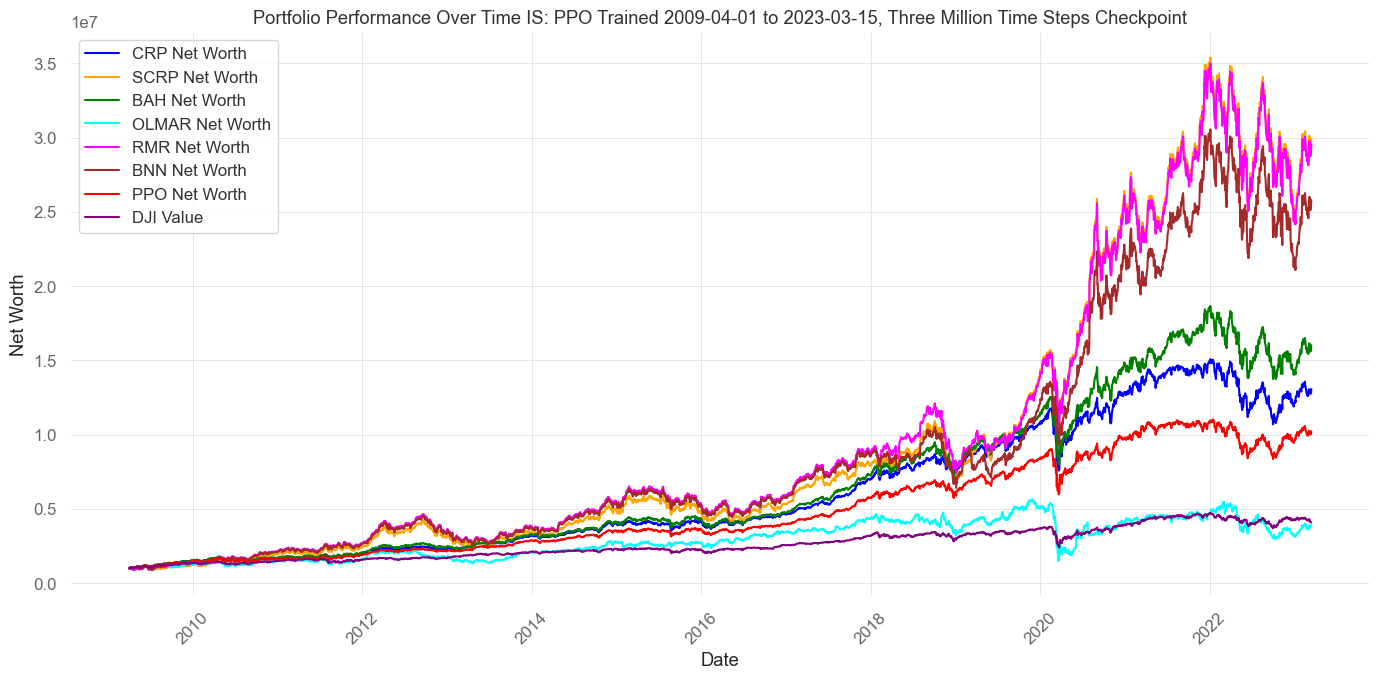

In [135]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time IS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [136]:
# Final returns

import pprint

final_returns = {
   'BCRP': merged_df['bcrp_opt_net_worth'].iloc[-1],
   'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
   'Hist. SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
   'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
   'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
   'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
   'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 16020297.0,
 'BCRP': 46185464.0,
 'BNN': 25799006.0,
 'CRP': 13069710.0,
 'Hist. SCRP': 29884096.0,
 'OLMAR': 3966011.0,
 'PPO': 10229185.0,
 'RMR': 29539746.0}


In [137]:
import numpy as np

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
# merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
# merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    # 'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    # 'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

pprint.pprint(sharpe_ratios)

{'BAH': 0.9431149920181052,
 'BCRP': 1.0347485740418183,
 'BNN': 0.8852961896507597,
 'CRP': 0.9187272640038794,
 'Hist. SCRP': 0.9216535590148579,
 'OLMAR': 0.402054157719527,
 'PPO': 0.9011442833880081,
 'RMR': 0.9173823396030721}


In [138]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'PPO': max_drawdown(merged_df['ppo_value']),
    # 'TD3': max_drawdown(merged_df['td3_value'])
}

pprint.pprint(max_drawdowns)


{'BAH': -0.363180442155278,
 'BCRP': -0.4379716838620611,
 'BNN': -0.4379717159802927,
 'CRP': -0.35611452276788824,
 'Hist. SCRP': -0.4379719470740324,
 'OLMAR': -0.7357712105950993,
 'PPO': -0.337933072245873,
 'RMR': -0.43797180097651645}


In [139]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'CRP_opt_daily_return', 'BCRP_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq       df         F    PR(>F)
Portfolio  0.000568      3.0  0.948827  0.415936
Residual   2.804005  14040.0       NaN       NaN
